# Paganin 

In [24]:
import numpy as np
import numpy.fft as fft

# ===== Constantes físicas =====
H_EVS = 4.135667696e-15   # h [eV·s]
C_MS  = 2.99792458e8      # c [m/s]

def wavelength_m(E_keV: float) -> float:
    """Longitud de onda λ(E) = hc/E  (E en keV) → [m]."""
    return (H_EVS * C_MS) / (E_keV * 1e3)

def paganin_simple(RAW: np.ndarray,
                   FF:  np.ndarray,
                   E_keV: float,
                   z_m: float,
                   pixel_m: float,
                   delta_eff: float,
                   mu_eff: float,
                   clip_min: float = 1e-12):
    """
    Paganin simple (DPM) para una energía.
    Parámetros:
      RAW, FF     : imágenes 2D propagadas (mismo tamaño)
      E_keV       : energía en keV
      z_m         : distancia muestra–detector [m]
      pixel_m     : tamaño de píxel [m]
      delta_eff   : δ efectivo del material (o del dominante, p.ej. PMMA)
      mu_eff      : μ efectivo [1/m] del mismo material
      clip_min    : mínimo para evitar log/fft de ceros

    Devuelve:
      T           : espesor proyectado [m]
      trans_filt  : transmisión filtrada (I/I0)_filt (adimensional)
    """

    # --- 1) Transmisión I/I0 ---
    trans = np.clip(RAW / np.clip(FF, clip_min, None), clip_min, None)

    # --- 2) Kernel Paganin (DPM): H = 1 / (1 + α (kx^2 + ky^2)) ---
    ny, nx = trans.shape
    u = np.fft.fftfreq(nx, d=pixel_m)                 # ciclos/m
    v = np.fft.fftfreq(ny, d=pixel_m)                 # ciclos/m
    kx, ky = np.meshgrid(2*np.pi*u, 2*np.pi*v)        # rad/m

    lam   = wavelength_m(E_keV)                       # [m]
    alpha = (lam * z_m / (2*np.pi)) * (delta_eff / mu_eff)  # [m^2]

    H = 1.0 / (1.0 + alpha * (kx**2 + ky**2))

    # --- 3) Filtrado en Fourier de la transmisión ---
    trans_filt = np.real(fft.ifft2(fft.fft2(trans) * H))
    trans_filt = np.clip(trans_filt, clip_min, None)

    # --- 4) Espesor proyectado (ec. 2.46) ---
    T = -(1.0 / mu_eff) * np.log(trans_filt)          # [m]

    return T, trans_filt


In [47]:
# Parámetros del montaje
E_keV   = 60.0         # energía
z_m     = 1.0          # distancia muestra–detector [m]
pixel_m = 55e-6       # tamaño de pixel [m]

# Propiedades efectivas (p.ej. del PMMA)
delta_eff = 7.3392E-08   # ejemplo
mu_eff    = 0.228523878968757*100       # [1/m], ejemplo (¡usa tus tablas/unidades correctas!)

# Cargar tus .txt (mismo tamaño)
RAW = np.loadtxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Geant4 Monocromaticas\RAW sumado\RAW_sum_60keV_1E10events.txt")
FF  = np.loadtxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Geant4 Monocromaticas\FF Sumado\FF_sum_60keV_1E10events.txt")

# Paganin simple
T_20keV, trans_filt_20keV = paganin_simple(
    RAW, FF, E_keV, z_m, pixel_m, delta_eff, mu_eff
)

# Guardar si quieres
# np.savetxt(r"C:\ruta\T_20keV.txt", T_20keV, fmt="%.8e")
np.savetxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Geant4 Monocromaticas\Paganin\TransFilt_60keV.txt", trans_filt_20keV, fmt="%.8e")

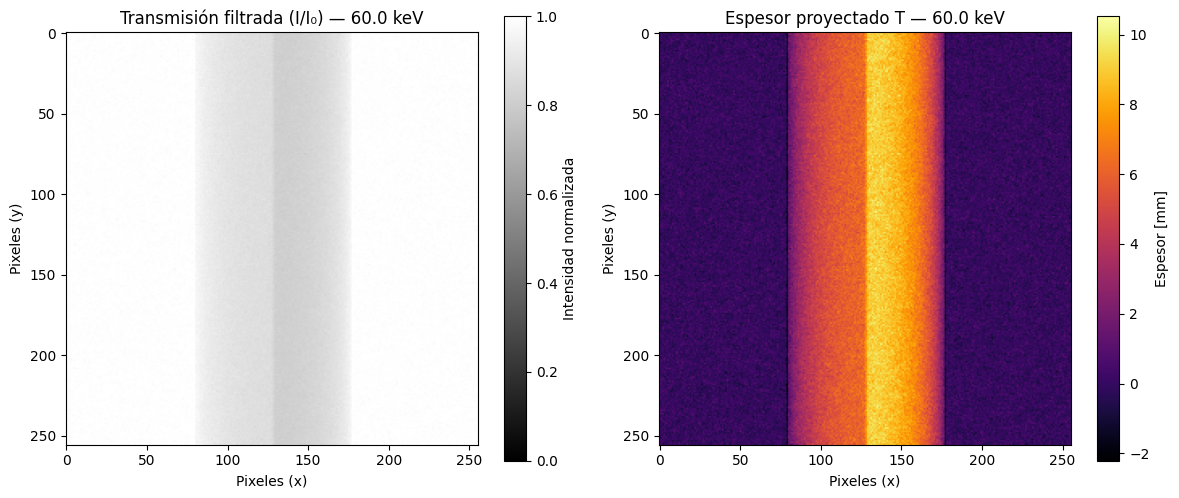

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# --- Asumiendo que ya tienes ---
# T, trans_filt = paganin_simple(RAW, FF, E_keV, z_m, pixel_m, delta_eff, mu_eff)

# Escala para graficar (en milímetros si T está en metros)
T_mm = T_20keV * 1e3

# --- 1. Gráficas lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Transmisión filtrada (adimensional, 0–1)
im1 = axes[0].imshow(trans_filt_20keV, cmap='gray', origin='upper', vmin=0, vmax=1)
axes[0].set_title(f"Transmisión filtrada (I/I₀) — {E_keV} keV")
axes[0].set_xlabel("Pixeles (x)")
axes[0].set_ylabel("Pixeles (y)")
plt.colorbar(im1, ax=axes[0], label="Intensidad normalizada")

# Espesor proyectado (T)
im2 = axes[1].imshow(T_mm, cmap='inferno', origin='upper')
axes[1].set_title(f"Espesor proyectado T — {E_keV} keV")
axes[1].set_xlabel("Pixeles (x)")
axes[1].set_ylabel("Pixeles (y)")
plt.colorbar(im2, ax=axes[1], label="Espesor [mm]")

plt.tight_layout()
plt.show()

# Paganin Beltran 

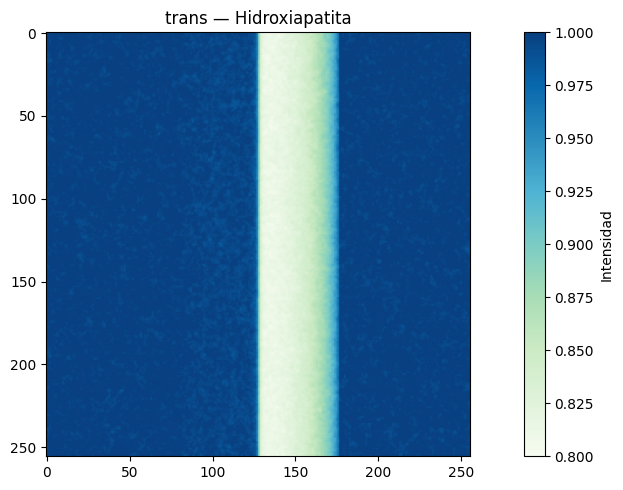

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft

# --------------------------------------------------------
# === PARÁMETROS FÍSICOS Y GEOMÉTRICOS ===
# --------------------------------------------------------

E_keV   = 60.0           # Energía [keV]
distance = 1.0           # Distancia muestra-detector [m]
pixel_size = 55e-6      # Tamaño de píxel [m]
clip = 1e-12             # Evitar divisiones por cero / log(0)

# --- Índices y coeficientes para cada material (ejemplo a 35 keV)
# δ (refractive index decrement) y μ (coeficiente de atenuación lineal) en [1/m]

# Fondo = PMMA
delta_PMMA = 6.7225E-08
mu_PMMA    = 0.218927299119043 * 100

# Inclusión 1 = Alúmina
#delta_Al   = 2.2566e-07
#mu_Al      = 0.94831E+00 * 100

# Inclusión 2 = Hidroxiapatita o mezcla 70-30
delta_HA   = 1.8256E-07
mu_HA      = 1.28459161068128*100

# --------------------------------------------------------
# === FUNCIONES AUXILIARES ===
# --------------------------------------------------------

H_EVS = 4.135667696e-15   # Constante de Planck [eV·s]
C_MS  = 2.99792458e8      # Velocidad de la luz [m/s]

def wavelength_m(E_keV):
    """Longitud de onda en metros."""
    return (H_EVS * C_MS) / (E_keV * 1e3)

def paganin_beltran(RAW, FF, E_keV, z_m, pixel_m, delta_j, delta_1, mu_j, mu_1):
    """
    Método Paganin-Beltrán para dos materiales (fondo 1, inclusión j).
    Devuelve la transmisión filtrada (I/I0)_filt.
    """
    Corr = np.clip(RAW / np.clip(FF, clip, None), clip, None)
    logR = np.log(Corr)

    # Frecuencias espaciales
    ny, nx = logR.shape
    u = np.fft.fftfreq(nx, d=pixel_m)
    v = np.fft.fftfreq(ny, d=pixel_m)
    kx, ky = np.meshgrid(2*np.pi*u, 2*np.pi*v)

    # Longitud de onda y término ν
    #lam = wavelength_m(E_keV)
    nu = (z_m * (delta_j - delta_1)) / (mu_j - mu_1)   # [m]
    H = 1.0 / (1.0 + nu * (kx**2 + ky**2))

    # Filtrado de Fourier
    logR_filt = np.real(fft.ifft2(fft.fft2(logR) * H))
    trans_filt = np.exp(logR_filt)
    trans_filt = np.clip(trans_filt, clip, 1.0)
    return trans_filt

# --------------------------------------------------------
# === CARGA DE IMÁGENES ===
# --------------------------------------------------------

RAW = np.loadtxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones monocromaticas para Aorta, sangre y placa\RAW sumado\RAWPLACASANGRE_sum_60keV_1E10events.txt")
FF  = np.loadtxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones monocromaticas para Aorta, sangre y placa\FF sumado\FFAorta_sum_60keV_1E10events.txt")

# --------------------------------------------------------
# === FILTRADO PARA CADA MATERIAL ===
# --------------------------------------------------------

#trans_filt_Al = paganin_beltran(RAW, FF, E_keV, distance, pixel_size,
 #                               delta_Al, delta_PMMA, mu_Al, mu_PMMA)

trans_filt_HA = paganin_beltran(RAW, FF, E_keV, distance, pixel_size,
                                delta_HA, delta_PMMA, mu_HA, mu_PMMA)

# --------------------------------------------------------
# === RESULTADOS VISUALES ===
# --------------------------------------------------------

#fE_Al = -np.log(trans_filt_Al)
#fE_HA = -np.log(trans_filt_HA)

plt.figure(figsize=(11,5))
plt.imshow(trans_filt_HA, cmap='GnBu')
plt.title("trans — Hidroxiapatita")
plt.colorbar(label='Intensidad')
plt.tight_layout()
plt.show()


np.savetxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones monocromaticas para Aorta, sangre y placa\paganin beltran\PaganinBeltran_MonoAortaSangrePaca_60keV.txt", trans_filt_HA, fmt="%.8e")
#np.savetxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Geant4 Monocromaticas\Paganin Beltran Al\trans_filt_Al_60keV.txt", trans_filt_Al, fmt="%.8e")


In [58]:
import numpy as np

# --- Constantes ---
r_e   = 2.8179403262e-15   # m
N_A   = 6.02214076e23      # 1/mol
h_eVs = 4.135667696e-15    # eV·s
c     = 2.99792458e8       # m/s

def wavelength_m(E_keV: float) -> float:
    """λ(E) en metros, con E en keV."""
    return (h_eVs * c) / (E_keV * 1e3)

def delta_from_composition(E_keV: float, rho_g_cm3: float, elements: list[dict]) -> float:
    """
    δ(E) = (r_e * λ^2 / 2π) * N_e
    OJO: rho en g/cm^3 -> g/m^3 (×1e6), A en g/mol, w fracción másica.
    """
    lam = wavelength_m(E_keV)                    # [m]
    rho_g_m3 = rho_g_cm3 * 1e6                   # g/cm^3 -> g/m^3
    sum_term = sum(e["w"] * e["Z"] / e["A"] for e in elements)  # (mol/g)*Z
    N_e = rho_g_m3 * N_A * sum_term              # e–/m^3
    return (r_e * lam**2 / (2*np.pi)) * N_e

def elements_alumina():
    """Fracciones másicas de Al2O3."""
    M = 2*26.9815 + 3*15.999  # g/mol
    w_Al = (2*26.9815) / M
    w_O  = (3*15.999)  / M
    return [
        {"Z": 13, "A": 26.9815, "w": w_Al},  # Al
        {"Z":  8, "A": 15.999 , "w": w_O },  # O
    ]

# ----- Parámetros -----
E_LIST = list(range(15, 61, 5))   # 15,20,...,60 keV
rho_alumina = 3.99                # g/cm^3

# ----- Cálculo δ(Al2O3, E) -----
els = elements_alumina()
delta_al = [delta_from_composition(E, rho_alumina, els) for E in E_LIST]

print("E_keV    delta_Al2O3")
for E, d in zip(E_LIST, delta_al):
    print(f"{E:>4}    {d:10.4e}")

# (opcional) guardar
# np.savetxt("delta_alumina_15_60keV.txt",
#            np.column_stack([E_LIST, delta_al]),
#            fmt=["%d", "%.6e"], header="E_keV   delta_Al2O3")


E_keV    delta_Al2O3
  15    3.6105e-06
  20    2.0309e-06
  25    1.2998e-06
  30    9.0262e-07
  35    6.6315e-07
  40    5.0773e-07
  45    4.0117e-07
  50    3.2494e-07
  55    2.6855e-07
  60    2.2566e-07


In [3]:
import numpy as np

# --- Energías ---
E = np.arange(15, 61, 5)  # 15, 20, ..., 60 keV

# --- δ de cada material (tus datos tabulados) ---
delta_pmma = np.array([
    1.1758E-06, 6.6103E-07, 4.2294E-07, 2.9366E-07,
    2.1573E-07, 1.6515E-07, 1.3049E-07, 1.0569E-07,
    8.7344E-08, 7.3392E-08
])

delta_ha = np.array([
    2.944E-06, 1.6515E-06, 1.0552E-06, 7.3198E-07,
    5.3738E-07, 4.1121E-07, 3.2478E-07, 2.6299E-07,
    2.173E-07, 1.8256E-07
])

# --- Fracciones volumétricas ---
f_pmma, f_ha = 0.70, 0.30

# --- δ mezcla (70 % PMMA + 30 % HA) ---
delta_mix = f_pmma * delta_pmma + f_ha * delta_ha

# --- Mostrar resultados ---
print("E_keV    δ_PMMA        δ_HA          δ_mix(70/30)")
for e, d1, d2, dm in zip(E, delta_pmma, delta_ha, delta_mix):
    print(f"{e:>4}   {d1:10.3e}   {d2:10.3e}   {dm:10.3e}")

# --- Chequeo δ·E² (debe ser casi constante si δ∝1/E²) ---
check = delta_mix * (E**2)
rel_range = np.ptp(check) / np.mean(check)
print(f"\nVariación relativa de δ·E² (mezcla): {rel_range*100:.2f}%")

# --- Guardar (opcional) ---
# np.savetxt("delta_mix_PMMHA_15_60keV.txt",
#            np.column_stack([E, delta_pmma, delta_ha, delta_mix]),
#            fmt=["%d", "%.6e", "%.6e", "%.6e"],
#            header="E_keV  δ_PMMA  δ_HA  δ_mix_70_30")


E_keV    δ_PMMA        δ_HA          δ_mix(70/30)
  15    1.176e-06    2.944e-06    1.706e-06
  20    6.610e-07    1.651e-06    9.582e-07
  25    4.229e-07    1.055e-06    6.126e-07
  30    2.937e-07    7.320e-07    4.252e-07
  35    2.157e-07    5.374e-07    3.122e-07
  40    1.651e-07    4.112e-07    2.390e-07
  45    1.305e-07    3.248e-07    1.888e-07
  50    1.057e-07    2.630e-07    1.529e-07
  55    8.734e-08    2.173e-07    1.263e-07
  60    7.339e-08    1.826e-07    1.061e-07

Variación relativa de δ·E² (mezcla): 0.47%
